# if on colab

In [1]:
# !git clone https://github.com/Hen0k/causal-inference.git
# %cd "causal-inference/notebooks"
# !apt-get install graphviz graphviz-dev -q
# !pip install pygraphviz -q
# !pip install causalnex -q

# Handle Imports

In [2]:
import sys
sys.path.append("../scripts/")

from causalnex.discretiser import Discretiser

# custom modules import
from fetch_data import DataLoader
from visualization import Plotters
from causal_graph import CausalGraph


loader = DataLoader()
plotters = Plotters(w=10, h=10)

/home/hat/miniconda3/envs/causality/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Learning the Structure

As the number of variables grows, or when domain knowledge does not exist, it can be tedious to define a structure manually. We can use CausalNex to learn the structure model from data. The structure learning algorithm we are going to use here is the NOTEARS algorithm.

When learning structure, we can use the entire dataset. Since structure should be considered as a joint effort between machine learning and domain experts, it is not always necessary to use a train / test split.

But before we begin, we have to pre-process the data so that the NOTEARS algorithm can be used.

In [3]:
data = loader.dvc_get_data(path="./data/data.csv",
                                  version="cleaned_data",
                                  repo="../")
cols_to_keep = ['perimeter_mean',
                'perimeter_worst',
                'area_se',
                'area_mean',
                'area_worst']
struct_data = data[cols_to_keep]
struct_data["target"] = data["diagnosis"]


DVC: CSV file read with path: ./data/data.csv | version: cleaned_data | from: ../


In [4]:
struct_data.head()

,perimeter_mean,perimeter_worst,area_se,area_mean,area_worst,target
0,122.80,184.60,153.40,1001.0,2019.0,1
1,132.90,158.80,74.08,1326.0,1956.0,1
2,130.00,152.50,94.03,1203.0,1709.0,1
3,77.58,98.87,27.23,386.1,567.7,1
4,135.10,152.20,94.44,1297.0,1575.0,1


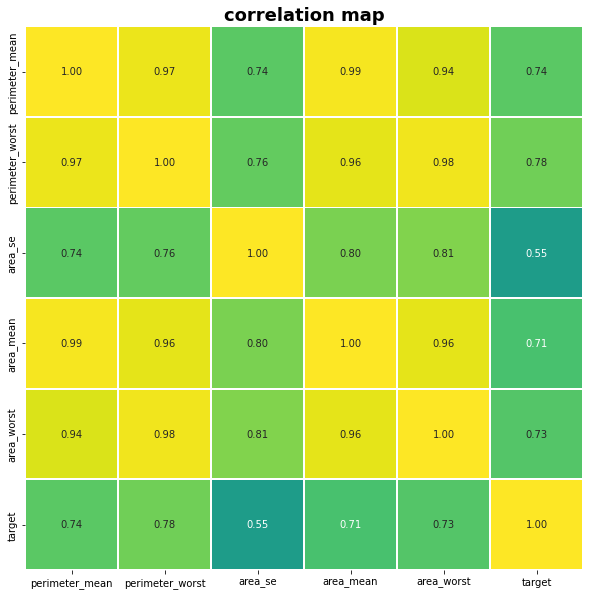

In [5]:
plotters.plot_heatmap(struct_data.corr(), "correlation map")

# Split the data
start at 50%, use it to generate the graph and gradually add portions of the holdout set to test the graphs stability

In [6]:
struct_data.shape

(569, 6)

In [7]:
train_set = struct_data.iloc[:len(struct_data)//2, :]
holdout_set = struct_data.iloc[len(struct_data)//2:, :]
print(f"Train set shape: {train_set.shape}\nHoldout set shape: {holdout_set.shape}")

Train set shape: (284, 6)
Holdout set shape: (285, 6)


In [8]:
cg = CausalGraph(train_set)

In [9]:
cg.learn_graph(w_threshold=0.7, beta=0.8)

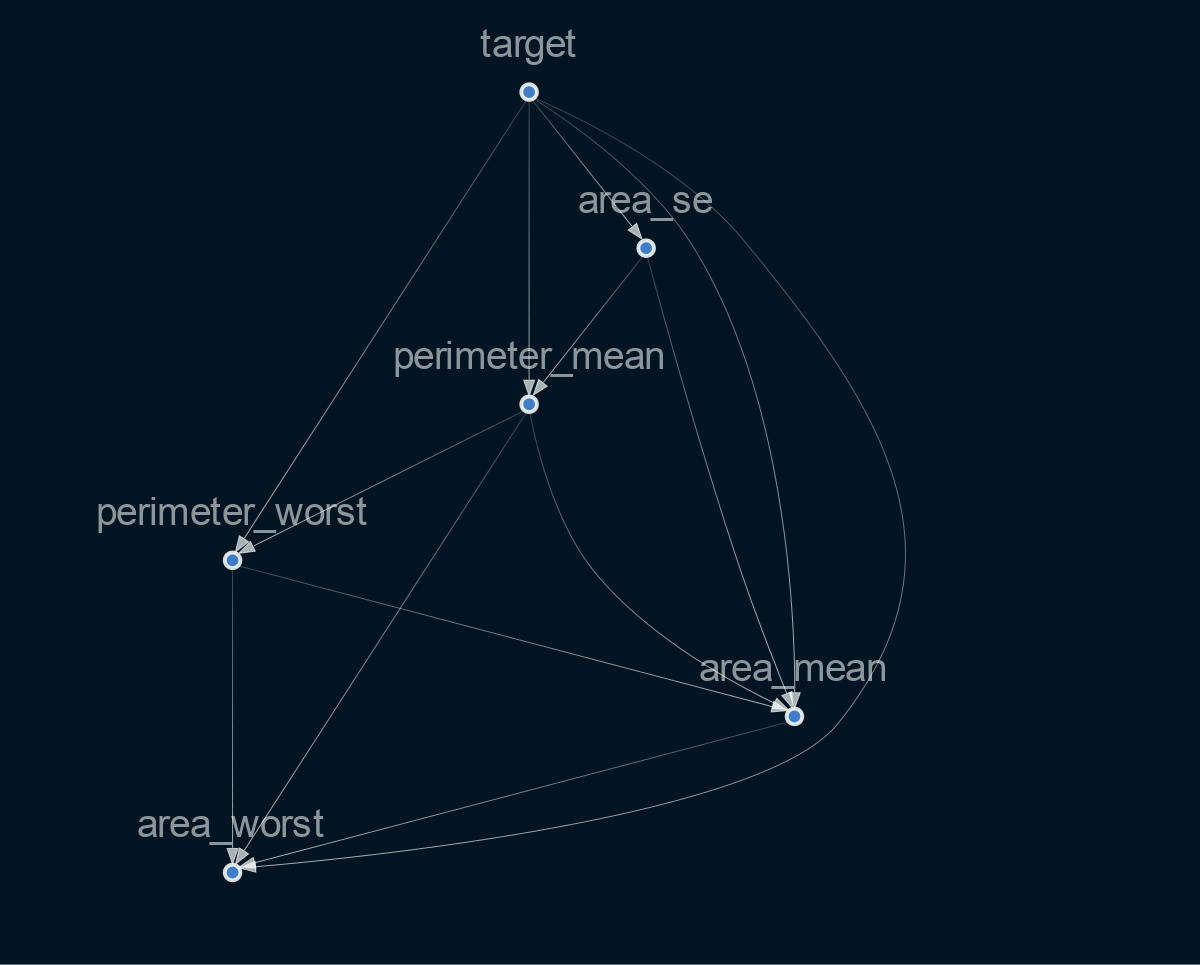

In [10]:
cg.show_graph(save=True)

In [ ]:
cg.save_graph("with_fifty_pct.dot")

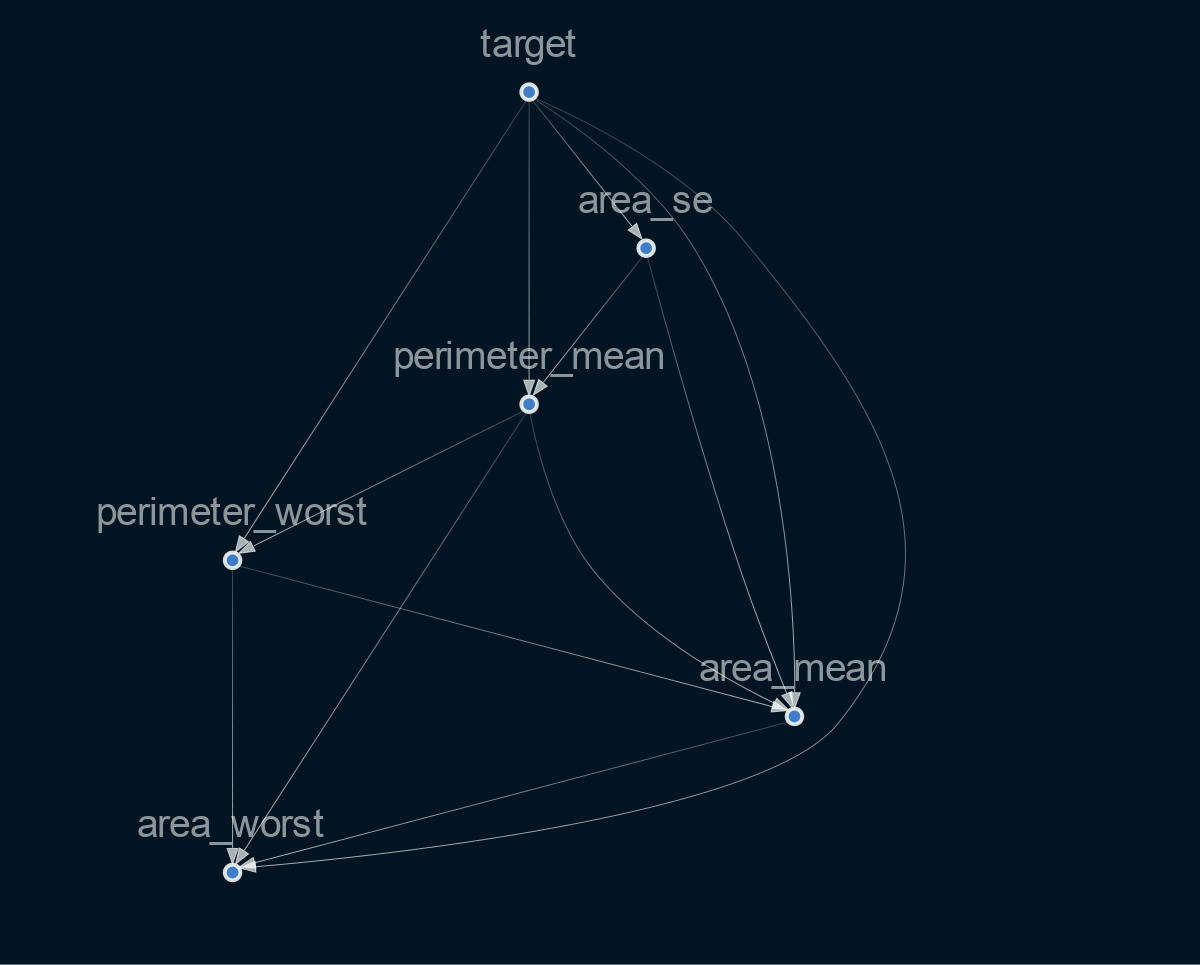

In [25]:
cg.sm = cg.sm.reverse()
cg.show_graph(save=True)

## 60%

In [ ]:
fifth = len(holdout_set)//5
train_set = train_set.append(holdout_set.iloc[:fifth, :])

In [33]:
cg2 = CausalGraph(train_set)
cg2.learn_graph()

In [ ]:
cg2.save_graph("with_sixty_pct.dot")

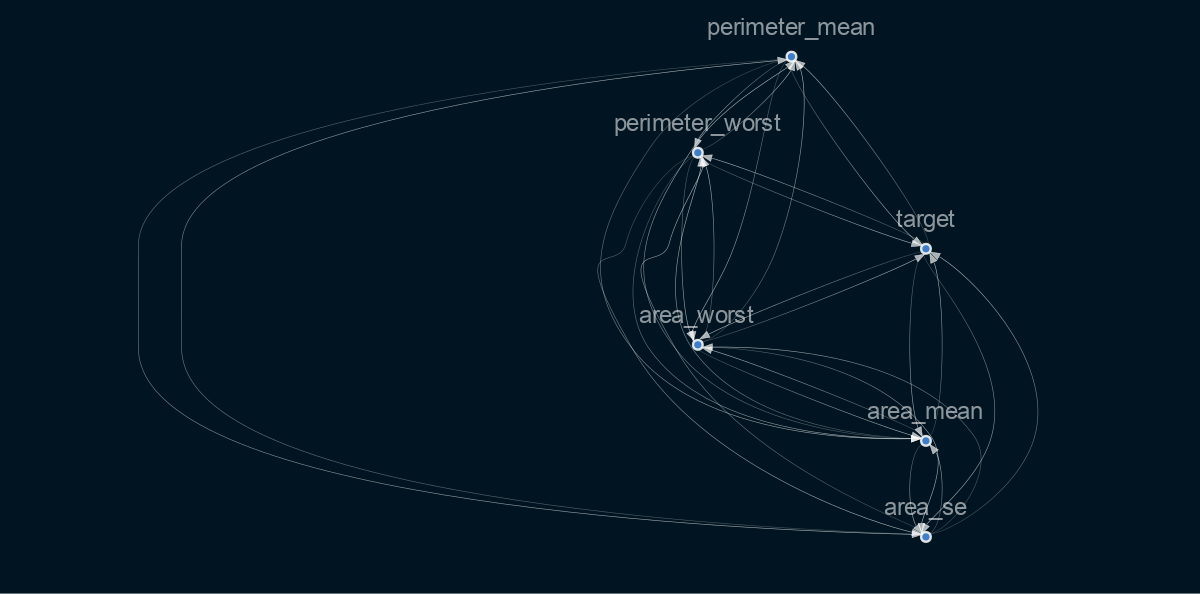

In [34]:
cg2.show_graph(save=True)

In [35]:
CausalGraph.jaccard_similarity(cg.sm.edges, cg2.sm.edges)

0.433

In [36]:
cg2.remove_edges_below_threshold(0.8)

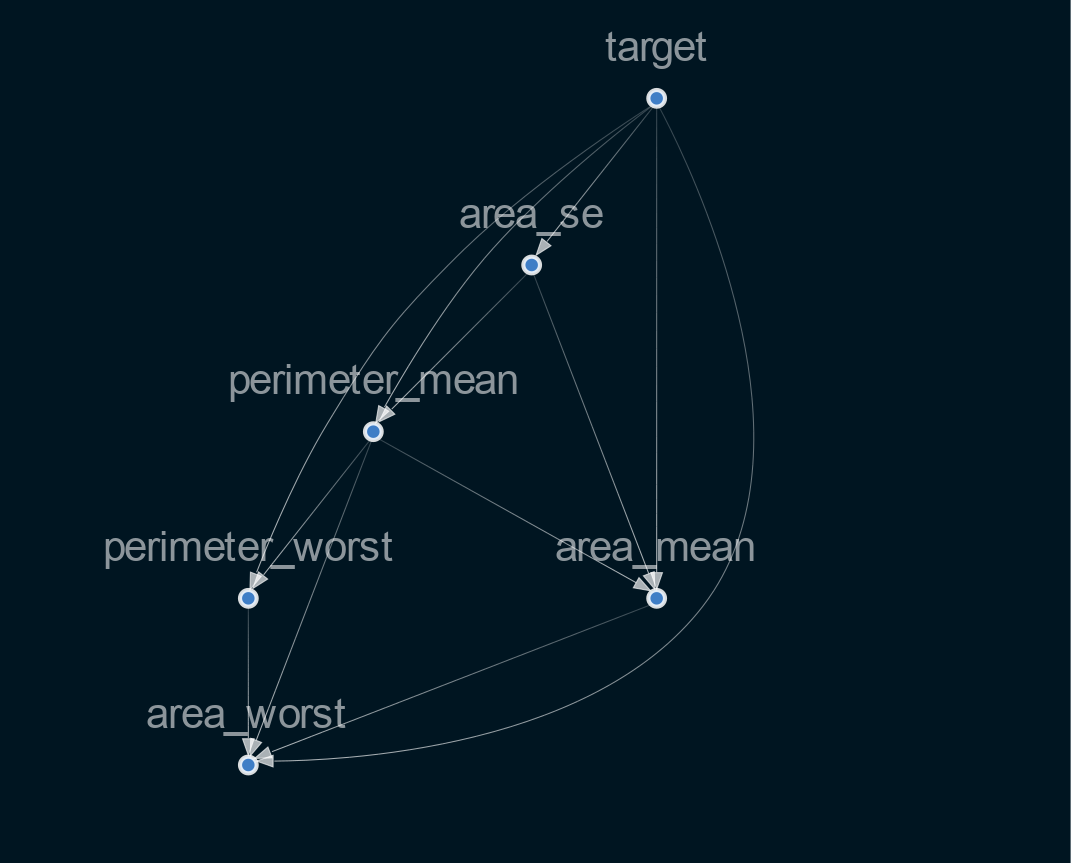

In [37]:
cg2.show_graph(save=False)

In [38]:
CausalGraph.jaccard_similarity(cg.sm.edges, cg2.sm.edges)

0.923

## 70%

In [39]:
fifth = len(holdout_set)//5
train_set = train_set.append(holdout_set.iloc[:2*fifth, :])
train_set.shape

(398, 6)

In [40]:
cg3 = CausalGraph(train_set)
cg3.learn_graph()

In [ ]:
cg3.save_graph("with_seventy_pct.dot")

## 80%

In [41]:
fifth = len(holdout_set)//5
train_set = train_set.append(holdout_set.iloc[:3*fifth, :])
train_set.shape

(569, 6)

In [42]:
cg4 = CausalGraph(train_set)
cg4.learn_graph()

In [ ]:
cg4.save_graph("with_eighty_pct.dot")

# 90%

In [ ]:
fifth = len(holdout_set)//5
train_set = train_set.append(holdout_set.iloc[:4*fifth, :])
train_set.shape

In [ ]:
cg5 = CausalGraph(train_set)
cg5.learn_graph()

In [ ]:
cg5.save_graph("with_ninety_pct.dot")

## 100%

In [ ]:
fifth = len(holdout_set)//5
train_set = train_set.append(holdout_set.iloc[:5*fifth, :])
train_set.shape

In [ ]:
cg6 = CausalGraph(train_set)
cg6.learn_graph()

In [ ]:
cg6.save_graph("with_hundread_pct.dot")

# Bayesian Network

In [ ]:
from causalnex.network import BayesianNetwork
# sm = sm.get_largest_subgraph()
bn = BayesianNetwork(sm)

## Discritize

In [ ]:

discretised_data = train_set.copy()
discretised_data.head()

In [ ]:
for col in discretised_data.columns:
    discretised_data[col] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data[col].values)

In [ ]:
target_map = {0: "Benign", 1: "Malignent"}
discretised_data["target"] = discretised_data["target"].map(target_map)


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

In [ ]:
bn = bn.fit_node_states(discretised_data)

In [ ]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [ ]:
bn